In [71]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import chi2_contingency

# Подготовка данных

Набор данных включает в себя такую ​​информацию, как 

* тип подписки пользователя (Basic, Standard или Premium)
* ежемесячный доход, полученный от его подписки
* дата присоединения к Netflix (Join Date)
* дата последнего платежа (Last Payment Date)
* страна, в которой он находится
* Возраст
* Пол
* тип устройства (например, Smart TV, мобильный телефон, настольный компьютер, планшет)
* Продолжительность подписки (я так поняла у всех стандартная 1 месяц)

In [38]:
df = pd.read_csv("/Users/tatianasalamatova/reps/MTS_data_analysis/stats_04/Netflix_Userbase.csv", sep = ",")
df

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month
...,...,...,...,...,...,...,...,...,...,...
2495,2496,Premium,14,25-07-22,12-07-23,Spain,28,Female,Smart TV,1 Month
2496,2497,Basic,15,04-08-22,14-07-23,Spain,33,Female,Smart TV,1 Month
2497,2498,Standard,12,09-08-22,15-07-23,United States,38,Male,Laptop,1 Month
2498,2499,Standard,13,12-08-22,12-07-23,Canada,48,Female,Tablet,1 Month


*Генерирую случайных пользователей, чтобы сделать датасет размером 200к уникальных пользователей*

In [39]:
# Сначала получу уникальные возможные значения в каждом столбце:
Subscription_Type = df['Subscription Type'].unique()
# Monthly_Revenue = df['Monthly Revenue'].unique() - не будут брать, сгенерирую сама
Country = df['Country'].unique()
Age_max = max(df['Age'])
Age_min = min(df['Age'])
Device = df['Device'].unique()
max_user_id = max(df['User ID'])

# Join Date - буду генерировать случайно в диапазоне с 21 по 23 год
# Last Payment Date	- буду генерировать случайно в течение 23 года с июня по июль
# Age - буду генерировать случайно от макс до мин
# Gender - очевидно, что случайно
# Plan duration - у всех один = 1 month

Генерирую случайную дату в заданном диапазоне, которая возвращает случайную дату в заданном интервале между двумя датами.

In [40]:
# def random_date(start, end):
    # return start + timedelta(seconds=random.randint(0, int((end - start).total_seconds())))

def random_date(start, end):
    delta = end - start
    random_days = random.randint(0, delta.days)
    return start + timedelta(days=random_days)

Рассчитаю дисперсию, которую буду использовать для генерации выборки дохода по нормальному распределению

In [41]:
variance_sub = df.groupby('Subscription Type')['Monthly Revenue'].var()

print(variance_sub)

Subscription Type
Basic       2.829066
Premium     3.004395
Standard    2.713234
Name: Monthly Revenue, dtype: float64


Генерирую пользователя:

In [42]:
def generate_user(user_id):
    join_date = random_date(datetime(2021, 1, 1), datetime(2023, 12, 31))  # буду генерировать случайно в диапазоне с 21 по 23 год
    last_payment_date = random_date(datetime(2023, 6, 1), datetime(2023, 7, 31))  # буду генерировать случайно в течение 23 года  с июня по июль
    age = random.randint(Age_min, Age_max)  # буду генерировать случайно от макс до мин
    gender = random.choice(['Male', 'Female'])   # случайный пол
    
    # сгенерирую доход Monthly Revenue, но не случайно, а в зависимости от типа подписки, логично, что пользователи
    # разных подписок будут тратить разное кол - во денег. И еще сделаю их float. Пусть это будет доход в долларах
    # а интервал от 5 долларов до 100 долларов (какие - то крутые юзеры).
    # Я понимаю, что у меня есть 2500 пользователей с целыми доходами (я их не хочу менять)
    subscription_type = random.choice(Subscription_Type)
    
    if subscription_type == 'Premium':
        mean = 80
        std_dev = variance_sub['Premium']
        monthly_revenue = round(np.random.normal(mean, std_dev), 2)
    elif subscription_type == 'Standard':
        mean = 50
        std_dev = variance_sub['Standard']
        monthly_revenue = round(np.random.normal(mean, std_dev), 2)
    else:
        mean = 20
        std_dev = variance_sub['Basic']
        monthly_revenue = round(np.random.normal(mean, std_dev), 2)

    # чтобы не было экстремальных концов
    if monthly_revenue < 10:
        monthly_revenue = 10
    elif monthly_revenue > 100:
        monthly_revenue = 100

    return {
        'User ID': user_id,
        'Subscription Type': subscription_type,
        'Monthly Revenue': monthly_revenue,
        'Join Date': join_date.strftime('%d-%m-%y'),
        'Last Payment Date': last_payment_date.strftime('%d-%m-%y'),
        'Country': random.choice(Country),
        'Age': age,
        'Gender': gender,
        'Device': random.choice(Device),
        'Plan Duration': '1 Month'  # У всех один и тот же план
    }

In [43]:
new_users = [generate_user(i) for i in range(max_user_id + 1, max_user_id + 200000)]
new_users_df = pd.DataFrame(new_users)

Присоединяю таблицу к имеющейся:

In [44]:
df_analysis = pd.concat([df, new_users_df], ignore_index=True)
print(df_analysis.shape)

(202499, 10)


In [45]:
df_analysis

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10.00,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month
1,2,Premium,15.00,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month
2,3,Standard,12.00,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12.00,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month
4,5,Basic,10.00,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month
...,...,...,...,...,...,...,...,...,...,...
202494,202495,Standard,48.76,28-04-22,28-07-23,United Kingdom,29,Male,Tablet,1 Month
202495,202496,Standard,52.51,25-10-21,22-07-23,Spain,46,Female,Smartphone,1 Month
202496,202497,Basic,22.75,01-09-21,24-06-23,France,46,Female,Laptop,1 Month
202497,202498,Basic,21.90,25-02-21,10-07-23,Australia,41,Male,Smart TV,1 Month


# Задание 1

Сформировать двухвыборочные гипотезы касательно медиан и распределений для дискретного и непрерывного случая. Если дискретного показателя нет - создайте его дополнительно. Итого 4 гипотезы (4 пункта)

Для моего датасета:

__Непрерывные метрики__: 

1) Monthly Revenue
2) Age

__Дискретные метрики__: 

1) Subscription Type
2) Country	
3) Gender	
4) Device

Даты сами по себе дискретны, но если я сделаю между ними разницу, чтобы смотреть интервалы или переведу их в часы/минуты/секунды и тд, тогда можно рассматривать как непрерывную

In [46]:
# Распределения буду смотреть по странам, поэтому выберу две самые частовстречающиеся
country_counts = df_analysis["Country"].value_counts()
country_counts

Country
Spain             20547
United States     20408
France            20342
Germany           20243
Canada            20214
United Kingdom    20206
Italy             20188
Australia         20139
Brazil            20129
Mexico            20083
Name: count, dtype: int64

### Гипотезы для __непрерывных__ метрик

* Для медиан:

**Буду использовать Критерий Уилкоксона-Манна-Уитни (двувыборочный, независимые выборки).** Но у критерия одно из условий предполагает, что функции распределения для обеих выборок имеют одинаковую форму. Поэтому ниже сначала проверю доп. гипотезу о равенстве распределений для двух типов подписок и, если все ок, применю его для медианы. Я понимаю, что я и так сгенерила нормальное распределение, но для правильности последовательности действий сделаю, потому что в реал экспериментах мы не знаем о типе распределения

$H_0$: Медиана дохода (Monthly Revenue) от пользователей подписки Premium равна медиане дохода от пользователей подписки Basic.

$$
\begin{aligned}
Med(X) = Med(Y)
\end{aligned}
$$

$H_1$: Медианы дохода (Monthly Revenue) от пользователей подписки Premium и Basic отличаются.

$$
\begin{aligned}
Med(X) \neq Med(Y)
\end{aligned}
$$


* Для распределений (гипотеза об однородности выборок):

**Здесь буду использовать критерий Колмогорова, он доказал, что для двувыборочного случая распределение Колмогорова подходит.**

$H_0$: Распределение возраста (Age) одинаково для пользователей из двух разных стран: Spain и United States.

$$
\begin{aligned}
H_0 : F_X \sim F_Y\\
\end{aligned}
$$

$H_1$: Распределение возраста различается для пользователей из двух стран: Spain и United States.

$$
\begin{aligned}
H_1 : F_X \nsim F_Y
\end{aligned}
$$

### Гипотезы для __дискретных__ метрик

* Для медиан:

**Буду использовать критерий Краскела-Уоллиса** 

$H_0$: Медианы количества устройств (Tablet, Smart TV, Smartphone, Laptop) одинаковы для всех типов подписок (Basic, Standard, Premium).


$$
\begin{aligned}
H_0: Med(\text{Smartphone})_{\text{Basic}} = Med(\text{Smartphone})_{\text{Standard}} = Med(\text{Smartphone})_{\text{Premium}}
\end{aligned}
$$

$$
\begin{aligned}
H_0: Med(\text{Tablet})_{\text{Basic}} = Med(\text{Tablet})_{\text{Standard}} = Med(\text{Tablet})_{\text{Premium}}
\end{aligned}
$$
$$
\begin{aligned}
H_0: Med(\text{Smart TV})_{\text{Basic}} = Med(\text{Smart TV})_{\text{Standard}} = Med(\text{Smart TV})_{\text{Premium}}
\end{aligned}
$$
$$
\begin{aligned}
H_0: Med(\text{Laptop})_{\text{Basic}} = Med(\text{Laptop})_{\text{Standard}} = Med(\text{Laptop})_{\text{Premium}}
\end{aligned}
$$

$H_1$: Медианы количества устройств различаются хотя бы для одного типа подписки.


* Для распределений (гипотеза об однородности выборок):

**Здесь буду использовать критерий Пирсона ($\chi^2$)**

$H_0$: Распределение типов устройств (Tablet, Smart TV, Smartphone, Laptop) одинаково для мужчин и для женщин.
$$
\begin{aligned}
H_0 : F_X \sim F_Y\\
\end{aligned}
$$

$H_1$: Распределение типов устройств (Tablet, Smart TV, Smartphone, Laptop) различается для мужчин и для женщин.

$$
\begin{aligned}
H_1 : F_X \nsim F_Y
\end{aligned}
$$

# Проверка гипотезы о равенстве медиан для непрерывного случая

На графике ниже видно, что доход по подпискам распределен одинаково и медианы не равны, покажу это с помощью тестов

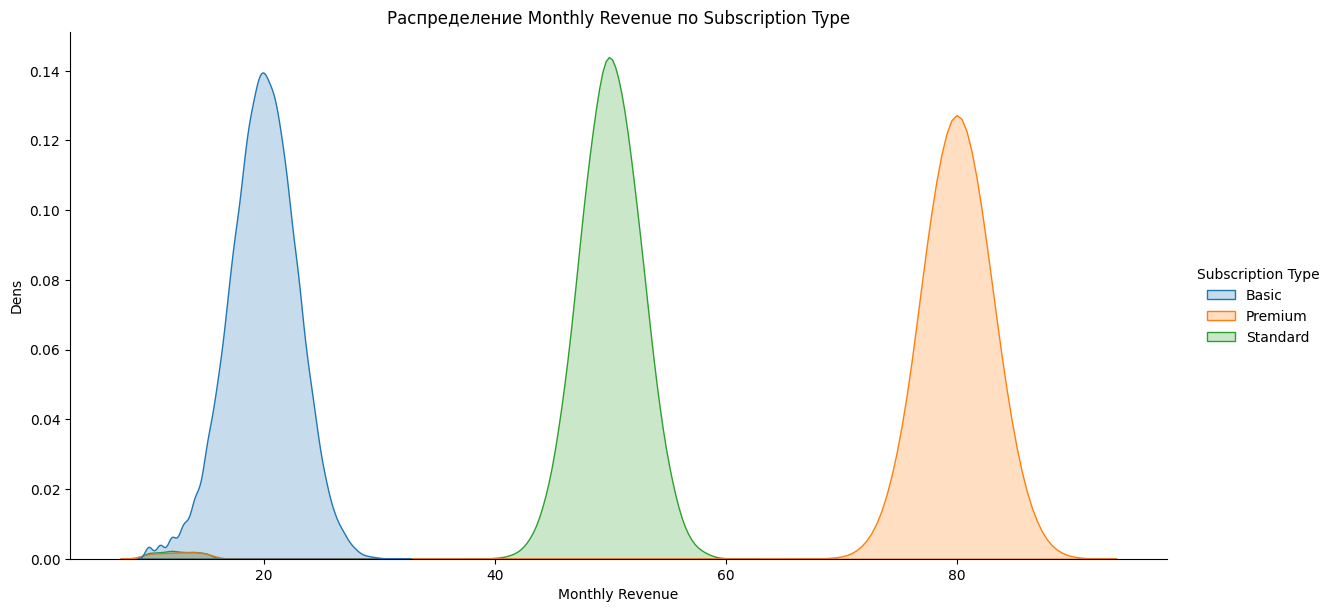

In [47]:
sns.displot(
    data=df_analysis,
    x="Monthly Revenue",
    hue="Subscription Type",
    kind="kde",
    fill=True,
    common_norm=False,
    height=6,
    aspect=2
)
plt.title("Распределение Monthly Revenue по Subscription Type")
plt.xlabel("Monthly Revenue")
plt.ylabel("Dens")
plt.show()

Проверка на то, что распределения для подписок премиум и базовая имеют одинаковые распределения.

p_value больше уровня значимости ($\alpha = 0.05$), не отвергаю нулевую гипотезу, => распределения одинаковы по форме.

In [57]:
premium_data = df[df['Subscription Type'] == 'Premium']['Monthly Revenue']
basic_data = df[df['Subscription Type'] == 'Basic']['Monthly Revenue']
ks_statistic, p_value = stats.ks_2samp(premium_data, basic_data)

print(p_value)
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: распределения разные по форме")
else:
    print("Не отвергаем нулевую гипотезу: распределения одинаковы по форме")

0.40231046526021297
Не отвергаем нулевую гипотезу: распределения одинаковы по форме


# Для проверки равенства медиан я выбрала критерий Уилкоксона-Манна-Уитни (двувыборочный, независимые выборки).

Это непараметрический тест, который учитывает порядок значений (ранги) и проверяет гипотезу о равенстве распределений двух выборок против альтернативной гипотезы, предполагающей сдвиг между ними. Если распределения действительно сдвинуты, то, по сути, мы обнаруживаем различия между медианами (а это как раз то, что мы проверяем).

Этот тест хорошо подходит, потому что:

* Он непараметрический, то есть не требует, чтобы данные были нормально распределены, и подходит даже для несимметричных распределений. Да, в моём случае данные симметричны (игрушечный пример), но сам подход универсален.

* Он работает с независимыми группами (Premium и Basic), что соответствует условиям задачи.

Как он работает: сначала данные из обеих выборок объединяются в общий вариационный ряд. Каждому наблюдению присваивается ранг — его позиция в этом ряду. Если значения совпадают, они получают одинаковый ранг, который считается средним для этой связки. Затем вычисляется сумма рангов отдельно для каждой группы. Если нулевая гипотеза верна (медианы равны), ранги распределяются случайно между выборками, и их суммы не будут существенно отличаться. Табличное распределение для статистики вычисляется перебором всех возможных комбинаций рангов.

In [78]:
premium_revenue = df_analysis[df_analysis["Subscription Type"] == "Premium"]["Monthly Revenue"]
basic_revenue = df_analysis[df_analysis["Subscription Type"] == "Basic"]["Monthly Revenue"]

u_stat, p_value = mannwhitneyu(premium_revenue, basic_revenue, alternative='two-sided')

print("Тест Уилкоксона-Манна-Уитни")
print(f"U-статистика: {u_stat}")
print(f"P-значение: {p_value}")
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: медианы отличаются")
else:
    print("Не отвергаем нулевую гипотезу: медианы равны")

Тест Уилкоксона-Манна-Уитни
U-статистика: 4528596998.0
P-значение: 0.0
Отвергаем нулевую гипотезу: медианы отличаются


Дополнительно покажу различие в медианах на histplotе

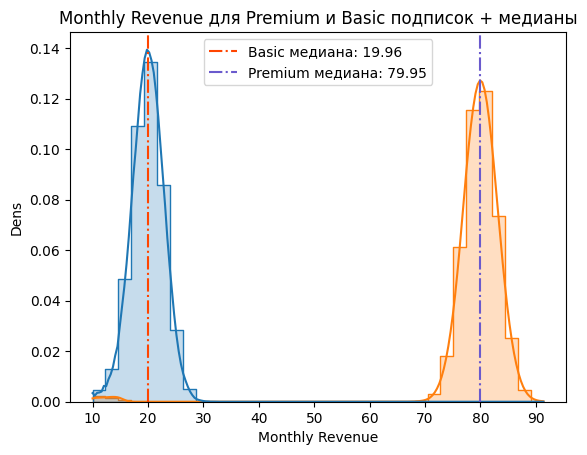

In [60]:
filtered = df_analysis[df_analysis["Subscription Type"].isin(["Premium", "Basic"])]

sns.histplot(
    data=filtered,
    x="Monthly Revenue",
    hue="Subscription Type",
    kde=True,
    element="step",
    stat="density",
    common_norm=False
)

median = (
    filtered.groupby("Subscription Type")["Monthly Revenue"].median()
)

colors = ['orangered', 'slateblue']
for (subscription, median_value), color in zip(median.items(), colors):
    plt.axvline(median_value, color=color, linestyle="-.", label=f"{subscription} медиана: {median_value}")

plt.title("Monthly Revenue для Premium и Basic подписок + медианы")
plt.xlabel("Monthly Revenue")
plt.ylabel("Dens")
plt.legend()
plt.show()

# Бутстрап для непрерывных медиан

95% доверительный интервал для Premium медианы: (79.93, 79.98)
95% доверительный интервал для Basic медианы: (19.93, 19.99)
Медианы значительно различаются.


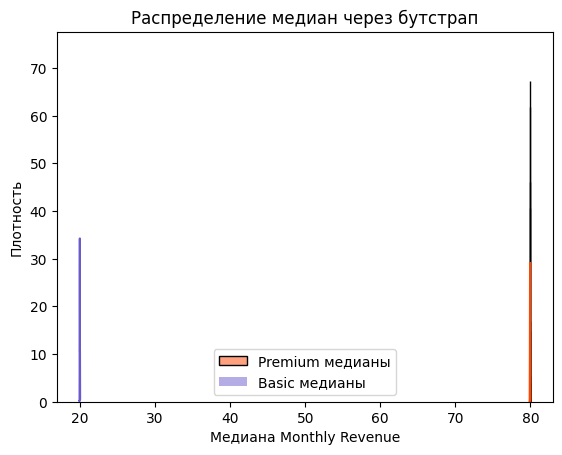

In [125]:
filt_sub = df_analysis[df_analysis["Subscription Type"].isin(["Premium", "Basic"])]

boot_iter = 1000
boot_m = {"Premium": [], "Basic": []}

for _ in range(boot_iter):
    for subscription in ["Premium", "Basic"]:
        sample = np.random.choice(filt_sub[filt_sub["Subscription Type"] == subscription]["Monthly Revenue"].values,
                                  size=len(filt_sub[filt_sub["Subscription Type"] == subscription]), replace=True)
        boot_m[subscription].append(np.median(sample))

boot_m["Premium"] = np.array(boot_m["Premium"])
boot_m["Basic"] = np.array(boot_m["Basic"])

lower_premium = np.percentile(boot_m["Premium"], 2.5)
upper_premium = np.percentile(boot_m["Premium"], 97.5)
lower_basic = np.percentile(boot_m["Basic"], 2.5)
upper_basic = np.percentile(boot_m["Basic"], 97.5)

print(f"95% доверительный интервал для Premium медианы: ({lower_premium}, {upper_premium})")
print(f"95% доверительный интервал для Basic медианы: ({lower_basic}, {upper_basic})")

if upper_premium < lower_basic or upper_basic < lower_premium:
    print("Медианы значительно различаются.")
else:
    print("Медианы не различаются значимо.")

sns.histplot(boot_m["Premium"], color="orangered", kde=True, label="Premium медианы", stat="density")
sns.histplot(boot_m["Basic"], color="slateblue", kde=True, label="Basic медианы", stat="density")

plt.title("Распределение медиан через бутстрап")
plt.xlabel("Медиана Monthly Revenue")
plt.ylabel("Плотность")
plt.legend()
plt.show()

# Проверка гипотезы о равенстве распределений для непрерывного случая

**Для распределений (гипотеза об однородности выборок) буду использовать распределение Колмогорова - Смирнова**

Потому что это непараметрический тест, который предназначен для сравнения двух эмпирических распределений и проверки гипотезы, что они принадлежат одному и тому же распределению. 

+ возраст пользователей из Spain и United States рассматривается как независимые выборки, что удовлетворяет условиям применения теста.
+ тест чувствителен к любым отличиям между распределениями, включая сдвиг медиан, различия в дисперсиях и тд.
+ не требует предположения о нормальности распределений или равенстве дисперсий

Напомню гипотезы:

$H_0$: Распределение возраста (Age) одинаково для пользователей из двух разных стран: Spain и United States.

$$
\begin{aligned}
H_0 : F_X \sim F_Y\\
\end{aligned}
$$

$H_1$: Распределение возраста различается для пользователей из двух стран: Spain и United States.

$$
\begin{aligned}
H_1 : F_X \nsim F_Y
\end{aligned}
$$

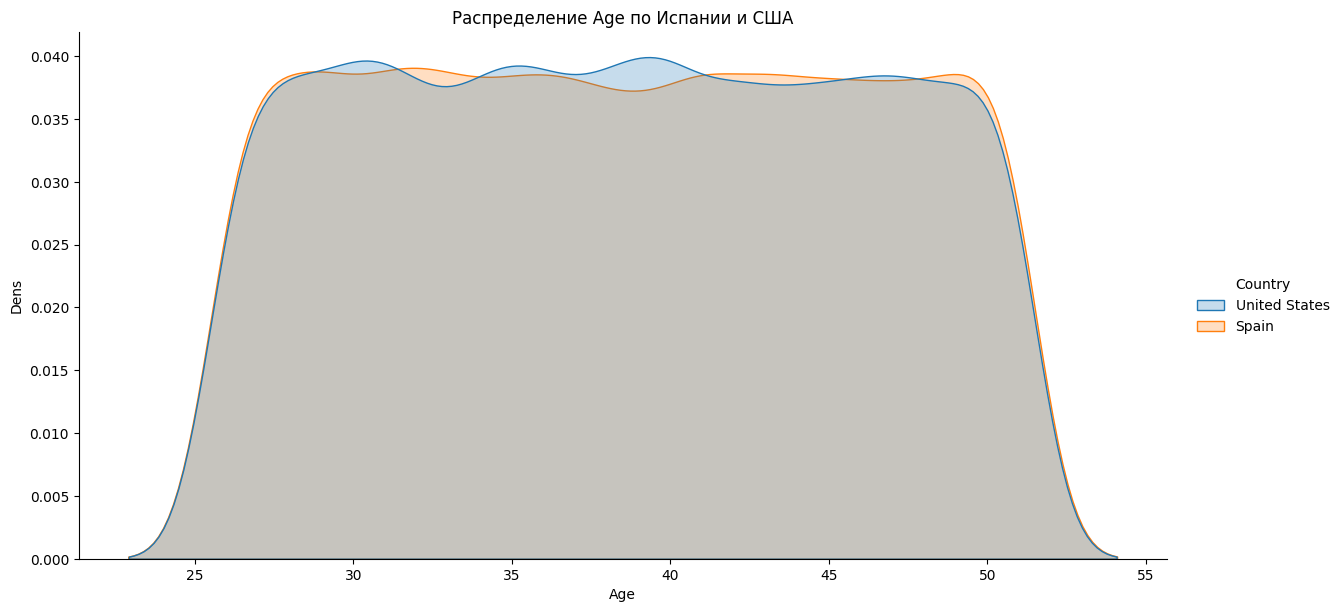

In [63]:
filtered_age = df_analysis[df_analysis['Country'].isin(['Spain', 'United States'])]

sns.displot(
    data=filtered_age,
    x="Age",
    hue="Country",
    kind="kde",
    fill=True,
    common_norm=False,
    height=6,
    aspect=2
)
plt.title("Распределение Age по Испании и США")
plt.xlabel("Age")
plt.ylabel("Dens")
plt.show()

Визуально распределения похожи (что и очевидно, я же их нагенерировала как равномерное распределение случаное), проверим на равенство распределения через критерий:

In [65]:
age_spain = df_analysis[df_analysis["Country"] == "Spain"]["Age"]
age_us = df_analysis[df_analysis["Country"] == "United States"]["Age"]

stat, p_value = stats.ks_2samp(age_spain, age_us)

print(f"KS-статистика: {stat}")
print(f"p-значение: {p_value}")

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: распределения возраста отличаются")
else:
    print("Не отвергаем нулевую гипотезу: распределения возраста одинаковые")

KS-статистика: 0.007977579565027426
p-значение: 0.5297709199257464
Не отвергаем нулевую гипотезу: распределения возраста одинаковые


# Бутстрап для равенства распределений (непрерывный случай)

Чтобы сравнить равенство распределений буду считать среднее значение (правильно же?). Нам нужно выбрать какую - то статистику

Наблюдаемая разница средних: 0.03509159007228391
95% доверительный интервал для разницы средних: (-0.10891054135295093, 0.18012272907377455)
Средние значения не различаются значимо, доверительный интервал включает 0


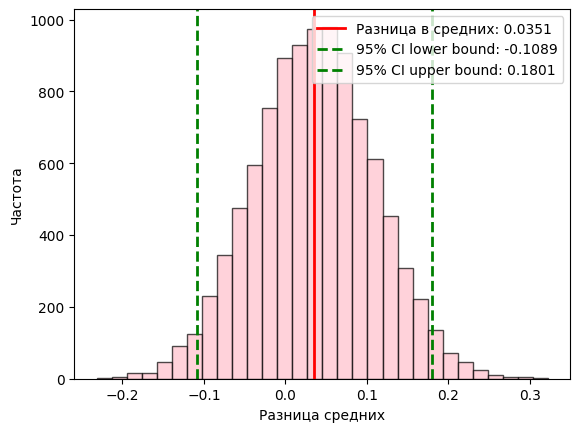

In [124]:
boot_iter = 10000
boot_diff = []

for _ in range(boot_iter):
    sample_spain = np.random.choice(age_spain, size=len(age_spain), replace=True)
    sample_us = np.random.choice(age_us, size=len(age_us), replace=True)
    
    boot_diff.append(np.mean(sample_spain) - np.mean(sample_us))

lower_bound = np.percentile(boot_diff, 2.5)
upper_bound = np.percentile(boot_diff, 97.5)

observed_difference = np.mean(age_spain) - np.mean(age_us)
print(f"Наблюдаемая разница средних: {observed_difference}")
print(f"95% доверительный интервал для разницы средних: ({lower_bound}, {upper_bound})")

if lower_bound > 0 or upper_bound < 0:
    print("Средние значения значительно различаются, доверительный интервал не включает 0")
else:
    print("Средние значения не различаются значимо, доверительный интервал включает 0")

plt.hist(boot_diff, bins=30, color="pink", edgecolor="black", alpha=0.7)
plt.axvline(observed_difference, color="red", linestyle="-", linewidth=2, label=f"Разница в средних: {observed_difference:.4f}")
plt.axvline(lower_bound, color="green", linestyle="--", linewidth=2, label=f"95% CI lower bound: {lower_bound:.4f}")
plt.axvline(upper_bound, color="green", linestyle="--", linewidth=2, label=f"95% CI upper bound: {upper_bound:.4f}")
plt.xlabel("Разница средних")
plt.ylabel("Частота")
plt.legend()
plt.show()

# Гипотезы для дискретных параметров

* Для медиан:

**Буду использовать критерий Краскела-Уоллиса** 

$H_0$: Медианы количества устройств (Tablet, Smart TV, Smartphone, Laptop) одинаковы для всех типов подписок (Basic, Standard, Premium).


$$
\begin{aligned}
H_0: Med(\text{Smartphone})_{\text{Basic}} = Med(\text{Smartphone})_{\text{Standard}} = Med(\text{Smartphone})_{\text{Premium}}
\end{aligned}
$$

$$
\begin{aligned}
H_0: Med(\text{Tablet})_{\text{Basic}} = Med(\text{Tablet})_{\text{Standard}} = Med(\text{Tablet})_{\text{Premium}}
\end{aligned}
$$
$$
\begin{aligned}
H_0: Med(\text{Smart TV})_{\text{Basic}} = Med(\text{Smart TV})_{\text{Standard}} = Med(\text{Smart TV})_{\text{Premium}}
\end{aligned}
$$
$$
\begin{aligned}
H_0: Med(\text{Laptop})_{\text{Basic}} = Med(\text{Laptop})_{\text{Standard}} = Med(\text{Laptop})_{\text{Premium}}
\end{aligned}
$$

$H_1$: Медианы количества устройств различаются хотя бы для одного типа подписки.

Использую этот критерий, потому что:

* у меня три типа подписки (было бы 2, можно было бы взять Манна-Уитни). Просто решила проверить можно ли так? и получить обратную связь.
* данные независимые

In [137]:
# делаю тест Краскела-Уоллиса для каждого устройства (Smartphone, Tablet, Smart TV, Laptop).
# Данные группирую по типам подписки: 'Basic', 'Standard', 'Premium'.

devices = ['Smartphone', 'Tablet', 'Smart TV', 'Laptop']

for device in devices:
    basic = df_analysis[(df_analysis['Subscription Type'] == 'Basic') & (df_analysis['Device'] == device)]
    standard = df_analysis[(df_analysis['Subscription Type'] == 'Standard') & (df_analysis['Device'] == device)]
    premium = df_analysis[(df_analysis['Subscription Type'] == 'Premium') & (df_analysis['Device'] == device)]

    basic_usr = basic['User ID'].count()
    standard_usr = standard['User ID'].count()
    premium_usr = premium['User ID'].count()

    stat, p_val = kruskal(basic_usr, standard_usr, premium_usr)
    
    print(f"Уст-во: {device}")
    print(f"Статистика: {stat}, p-value: {p_val}")
    
    if p_val < 0.05:
        print(f"Отвергаем нулевую гипотезу для устройства {device}: медианы различаются.\n")
    else:
        print(f"Не отвергаем нулевую гипотезу для устройства {device}: медианы одинаковы.\n")

Уст-во: Smartphone
Статистика: 2.0, p-value: 0.36787944117144245
Не отвергаем нулевую гипотезу для устройства Smartphone: медианы одинаковы.

Уст-во: Tablet
Статистика: 2.0, p-value: 0.36787944117144245
Не отвергаем нулевую гипотезу для устройства Tablet: медианы одинаковы.

Уст-во: Smart TV
Статистика: 2.0, p-value: 0.36787944117144245
Не отвергаем нулевую гипотезу для устройства Smart TV: медианы одинаковы.

Уст-во: Laptop
Статистика: 2.0, p-value: 0.36787944117144245
Не отвергаем нулевую гипотезу для устройства Laptop: медианы одинаковы.



# Итак, тип подписки не влияет на количество используемых устройств, и медианы количества устройств одинаковы между всеми типами подписок

In [144]:
def kruskal_like_bootstrap(device_name, df, boot_iter=1000):
    
    basic = df[(df['Subscription Type'] == 'Basic') & (df['Device'] == device_name)]
    standard = df[(df['Subscription Type'] == 'Standard') & (df['Device'] == device_name)]
    premium = df[(df['Subscription Type'] == 'Premium') & (df['Device'] == device_name)]

    # сколько пользователей в каждой группе?
    basic_usr = basic['User ID'].values
    standard_usr = standard['User ID'].values
    premium_usr = premium['User ID'].values
    
    def bootstrap_median(sample):
        return np.median(np.random.choice(sample, size=len(sample), replace=True))
    
    boot_medians = {'Basic': [], 'Standard': [], 'Premium': []}

    for _ in range(boot_iter):
        boot_medians['Basic'].append(bootstrap_median(basic_usr))
        boot_medians['Standard'].append(bootstrap_median(standard_usr))
        boot_medians['Premium'].append(bootstrap_median(premium_usr))
    
    boot_diff_basic_standard = np.array(boot_medians['Basic']) - np.array(boot_medians['Standard'])
    boot_diff_basic_premium = np.array(boot_medians['Basic']) - np.array(boot_medians['Premium'])
    boot_diff_standard_premium = np.array(boot_medians['Standard']) - np.array(boot_medians['Premium'])
    
    lower_basic_standard = np.percentile(boot_diff_basic_standard, 2.5)
    upper_basic_standard = np.percentile(boot_diff_basic_standard, 97.5)
    lower_basic_premium = np.percentile(boot_diff_basic_premium, 2.5)
    upper_basic_premium = np.percentile(boot_diff_basic_premium, 97.5)
    lower_standard_premium = np.percentile(boot_diff_standard_premium, 2.5)
    upper_standard_premium = np.percentile(boot_diff_standard_premium, 97.5)
    
    print(f"Устройство: {device_name}")

    if lower_basic_standard > 0 or upper_basic_standard < 0:
        print(f"Медианы для Basic и Standard различаются.\n")
    else:
        print(f"Медианы для Basic и Standard не различаются.\n")

    if lower_basic_premium > 0 or upper_basic_premium < 0:
        print(f"Медианы для Basic и Premium различаются.\n")
    else:
        print(f"Медианы для Basic и Premium не различаются.\n")

    if lower_standard_premium > 0 or upper_standard_premium < 0:
        print(f"Медианы для Standard и Premium различаются.\n")
    else:
        print(f"Медианы для Standard и Premium не различаются.\n")

In [145]:
kruskal_like_bootstrap('Smartphone', df_analysis)

kruskal_like_bootstrap('Tablet', df_analysis)

kruskal_like_bootstrap('Laptop', df_analysis)

kruskal_like_bootstrap('Smart TV', df_analysis)

Устройство: Smartphone
Медианы для Basic и Standard не различаются.

Медианы для Basic и Premium не различаются.

Медианы для Standard и Premium не различаются.

Устройство: Tablet
Медианы для Basic и Standard не различаются.

Медианы для Basic и Premium не различаются.

Медианы для Standard и Premium не различаются.

Устройство: Laptop
Медианы для Basic и Standard не различаются.

Медианы для Basic и Premium не различаются.

Медианы для Standard и Premium не различаются.

Устройство: Smart TV
Медианы для Basic и Standard не различаются.

Медианы для Basic и Premium не различаются.

Медианы для Standard и Premium не различаются.



* Для распределений (гипотеза об однородности выборок):

**Здесь буду использовать критерий Пирсона ($\chi^2$)**

$H_0$: Распределение типов устройств (Tablet, Smart TV, Smartphone, Laptop) одинаково для мужчин и для женщин.
$$
\begin{aligned}
H_0 : F_X \sim F_Y\\
\end{aligned}
$$

$H_1$: Распределение типов устройств (Tablet, Smart TV, Smartphone, Laptop) различается для мужчин и для женщин.

$$
\begin{aligned}
H_1 : F_X \nsim F_Y
\end{aligned}
$$

Использую критерий Пирсона, потому что:

* !NB на лекции так сказали $:)$
* у меня дискретные данные: типы устройств. Критерий Пирсона ($\chi^2$) применяется для проверки гипотезы об однородности распределений категориальных переменных в разных группах (в данном случае, для разных полов).

* Видно из статистики, что он предназначен для дискретных:

__Статистика:__ 

$$
\sum_{j=1}^s \frac{(v_j - n \cdot p_j(\hat \theta))^2}{n \cdot p_j(\hat \theta)} \sim \chi^2_{s - k - 1},
$$

где $\hat \theta$ - любая состоятельная оценка параметра, $v_j$ - частота, с которой значение $j$ встречалось в выборке, $p_j$ - теоретическая вероятность того, что выпадет значение $j$,  $s$ - число значений, которые может принимать случайная величина, $k$ - размерность вектора параметров $\theta$

In [76]:
# Таблица сопряженности:

ct = pd.crosstab(df_analysis['Gender'], df_analysis['Device'])
chi2_stat, p_val, _, _ = chi2_contingency(ct)

print("Таблица сопряженности:\n")
print(ct)
print("\nРезультаты теста Пирсона:")
print(f"$\\chi^2$ статистика: {chi2_stat}")
print(f"P-значение: {p_val}")


# Интерпретация результатов
if p_val < 0.05:
    print("\nОтвергаем нулевую гипотезу: распределения типов устройств различаются для мужчин и женщин.")
else:
    print("\nНе отвергаем нулевую гипотезу: распределения типов устройств одинаковы для мужчин и женщин.")


Таблица сопряженности:

Device  Laptop  Smart TV  Smartphone  Tablet
Gender                                      
Female   25136     25121       25443   25217
Male     25334     25712       25403   25133

Результаты теста Пирсона:
$\chi^2$ статистика: 5.635754409288657
P-значение: 0.1307407398726701

Не отвергаем нулевую гипотезу: распределения типов устройств одинаковы для мужчин и женщин.


# Бутстрап для равенства распределений (дискретный случай)

Попоробую сделать бутстрап через пропорции: посмотрю, насколько различаются пропорции категорий в каждой переменной

In [131]:
def chi_like_boot(device_name, ct, boot_iter=100):

    fact_diff = ct.loc['Female', device_name] / ct.loc['Female'].sum() - ct.loc['Male', device_name] / ct.loc['Male'].sum()

    boot_dif = []

    for _ in range(boot_iter):
        sampled_female = np.random.choice(ct.loc['Female'].values, size=len(ct.columns), replace=True)
        sampled_male = np.random.choice(ct.loc['Male'].values, size=len(ct.columns), replace=True)
        
        new_ct = pd.DataFrame([sampled_female, sampled_male], columns=ct.columns, index=['Female', 'Male'])

        diff = new_ct.loc['Female', device_name] / new_ct.loc['Female'].sum() - new_ct.loc['Male', device_name] / new_ct.loc['Male'].sum()
        boot_dif.append(diff)

    lower_bound = np.percentile(boot_dif, 2.5)
    upper_bound = np.percentile(boot_dif, 97.5)

    print(f"95% доверительный интервал для разницы в пропорциях для устройства {device_name}: ({lower_bound}, {upper_bound})")

    if fact_diff < lower_bound or fact_diff > upper_bound:
        print(f"\nОтвергаем нулевую гипотезу: распределения {device_name} различаются для мужчин и женщин.")
    else:
        print(f"\nНе отвергаем нулевую гипотезу: распределения {device_name} одинаковы для мужчин и женщин.")

    plt.hist(boot_dif, bins=30, color="pink", edgecolor="gray", alpha=0.7)
    plt.axvline(np.mean(boot_dif), color="red", linestyle="--", linewidth=2, label=f"Средняя разница: {np.mean(boot_dif):.2f}")
    plt.axvline(lower_bound, color="green", linestyle="--", linewidth=2, label=f"95% CI lower bound: {lower_bound:.4f}")
    plt.axvline(upper_bound, color="green", linestyle="--", linewidth=2, label=f"95% CI upper bound: {upper_bound:.4f}")
    plt.title(f"Распределение через бутстрап для {device_name}")
    plt.xlabel("Разница в пропорциях")
    plt.ylabel("Частота")
    plt.legend()
    plt.show()


95% доверительный интервал для разницы в пропорциях для устройства Laptop: (-0.003824774063183644, 0.004173214065222023)

Не отвергаем нулевую гипотезу: распределения Laptop одинаковы для мужчин и женщин.


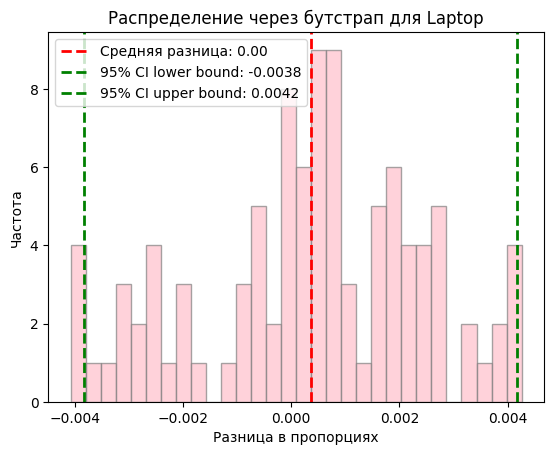

In [132]:
#для Laptop
chi_like_boot('Laptop', ct)

95% доверительный интервал для разницы в пропорциях для устройства Smartphone: (-0.0039048789421697225, 0.003302340240468451)

Не отвергаем нулевую гипотезу: распределения Smartphone одинаковы для мужчин и женщин.


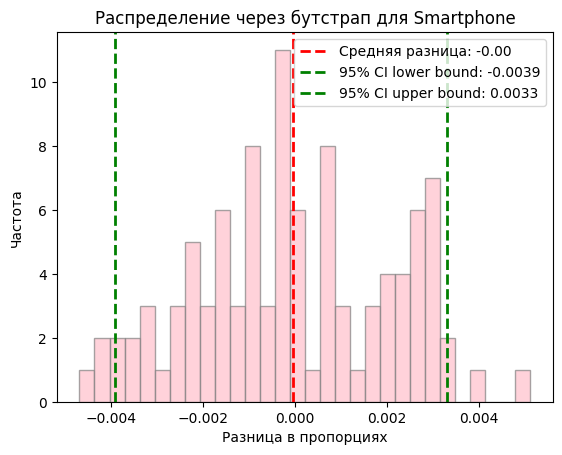

In [133]:
# Вызов функции для Smartphone
chi_like_boot('Smartphone', ct)

95% доверительный интервал для разницы в пропорциях для устройства Smart TV: (-0.004332903950594503, 0.004532655962829788)

Не отвергаем нулевую гипотезу: распределения Smart TV одинаковы для мужчин и женщин.


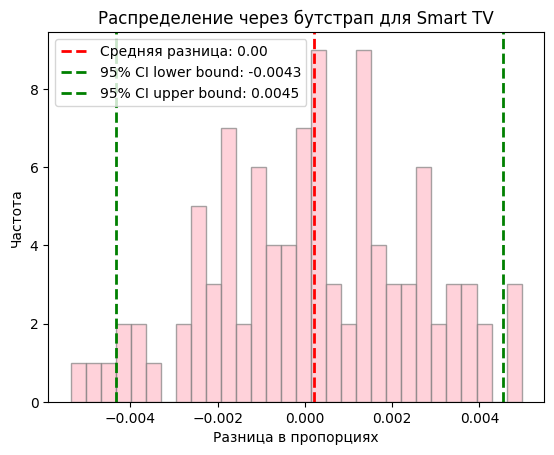

In [134]:
# Вызов функции для Smart TV
chi_like_boot('Smart TV', ct)

95% доверительный интервал для разницы в пропорциях для устройства Tablet: (-0.003890691317778252, 0.003830492751603572)

Не отвергаем нулевую гипотезу: распределения Tablet одинаковы для мужчин и женщин.


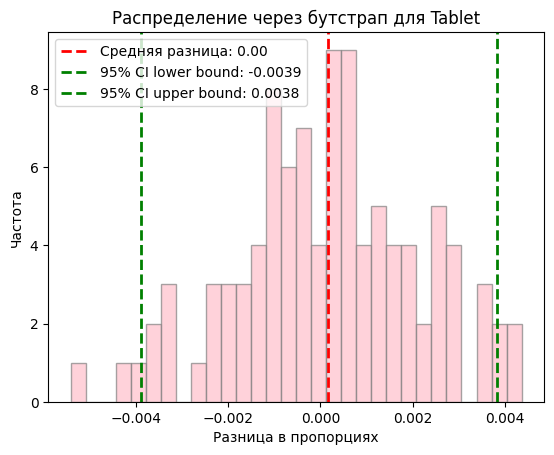

In [135]:
# Вызов функции для Tablet
chi_like_boot('Tablet', ct)

Мне кажется, бутстрап вообще не эффективен для таких дискретных параметров как у меня, потому что у меня всего две строки и четыре столбца

# Задание 2 - 3

Сравнить результаты из 4 пунктов с результатами бутстрапа и обосновать различия, если они есть

Определить какой подход мощнее в конкретном случае и почему

В результате выполнения тестов с использованием непараметрических критериев (Уилкоксона-Манна-Уитни, Колмогорова, Краскела-Уоллиса и Пирсона), а также бутстрапа, я пришла к выводу, что все методы дали __одинаковые__ результаты. Это можно объяснить тем, что мои данные достаточно "красиво" распределены. Например данные о доходах распределены нормально, а возраст равномерно. В таком случае, как видно, непараметрические тесты и бутстрап не демонстрируют существенных различий, поскольку оба подхода работают с эмпирическими данными, а не с параметрами распределений (как у параметрических под капотом), и оба дают хорошие результаты при отсутствии серьезных отклонений от нормальности или других сложных особенностей данных.

Но! различия между методами могли бы проявиться в случае, если данные имели бы жирные хвосты или были бы сильно асимметричными. Тогда непараметрические критерии, такие как тест Колмогорова, могли бы показать более худшие результаты, поскольку они не всегда адекватно справляются с сильными отклонениями или хвостами. А вот бутстрап,наверное, смог бы более точно отразить такие особенности данных, повторяя выборки и учитывая любые отклонения.

Однако, непараметрические тесты, такие как Уилкоксона-Манна-Уитни и Краскела-Уоллиса, обладают важным преимуществом - они устойчивы к выбросам. Потому, что они работают с рангами, а не с реальными значениями данных. Если в данных присутствуют выбросы, которые могут сильно исказить результаты, непараметрические методы, наоборот, помогают устранить их влияние. Это как плюс, так и минус: с одной стороны, выбросы могут сильно портить картину, а с другой — если эти выбросы действительно важны для исследования, то бутстрап будет более точным, так как в нем выбросы могут повторно попадать в выборки и учитываться при расчетах статистики.

Кроме того, бутстрап обычно оказывается более мощным для анализа непрерывных распределений, так как он строит распределения статистик непосредственно из данных и может учитывать их особенности, например, асимметрию или хвосты. В случае дискретных данных подход с бутстрапом становится менее эффективным, поскольку выборки из небольших количеств уникальных значений (например, для категориальных переменных или редких событий) не обеспечат большой вариативности.

Я могу сделать вывод, что если данные имеют нормальные или равномерные распределения, то различия между результатами непараметрических тестов и бутстрапа, как правило, не наблюдаются. Однако для данных с сильными отклонениями от нормальности, асимметриями или выбросами бутстрап будет более мощным инструментом, так как он учитывает все особенности распределений.